In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Загрузка данных
data = pd.read_csv('20newsgroups_selected_cleaned_translated.csv')
data.head()

,text,topic
0,"Хм.миллиард долларов, Меньше ... Я, вероятно, ...",космос
1,Пишет:> Может ли кто -нибудь рассказать мне о ...,христианство
2,"-*---- Я согласен со всем, что Lee Lady написа...",медицина
3,В статье (Джон Нгл) пишет:> (Брюс Г. Бостек) п...,электроника
4,"Здравствуйте, я пишу грантовое предложение для...",медицина


In [2]:
# Удаление строк с пропущенными значениями в столбце 'text'
data = data.dropna(subset=['text'])

In [3]:
# В датасете есть столбцы 'text' (текст статьи) и 'topic' (метка темы работы)
texts = data['text']
labels = data['topic']

In [4]:
# Преобразование меток в числовой формат
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [5]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(texts, encoded_labels, test_size=0.2, random_state=42)

In [6]:
# Преобразование текстов в TF-IDF векторы
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [7]:
# Произвести математический расчет нейронной сети. Выбрать функцию активации нейронной сети. Вычислить вес нейронов.
# Рассчитать оптимальную скорость обучения нейросети.
# Рассчитать процесс обратного распространения ошибки.
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Определение архитектуры модели
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Настройка ранней остановки
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Обучение модели
history = model.fit(
    X_train_tfidf.toarray(), y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/20
99/99 [==============================] - 21s 202ms/step - loss: 1.1099 - accuracy: 0.6495 - val_loss: 0.3294 - val_accuracy: 0.9040
Epoch 2/20
99/99 [==============================] - 8s 77ms/step - loss: 0.1554 - accuracy: 0.9576 - val_loss: 0.2264 - val_accuracy: 0.9217
Epoch 3/20
99/99 [==============================] - 11s 111ms/step - loss: 0.0281 - accuracy: 0.9953 - val_loss: 0.2235 - val_accuracy: 0.9268
Epoch 4/20
99/99 [==============================] - 14s 139ms/step - loss: 0.0090 - accuracy: 0.9987 - val_loss: 0.2223 - val_accuracy: 0.9255
Epoch 5/20
99/99 [==============================] - 14s 143ms/step - loss: 0.0057 - accuracy: 0.9991 - val_loss: 0.2254 - val_accuracy: 0.9268
Epoch 6/20
99/99 [==============================] - 14s 137ms/step - loss: 0.0044 - accuracy: 0.9994 - val_loss: 0.2280 - val_accuracy: 0.9242
Epoch 7/20
99/99 [==============================] - 14s 137ms/step - loss: 0.0068 - accuracy: 0.9994 - val_loss: 0.2354 - val_accuracy: 0.9268


In [8]:
# Оценка модели на тестовых данных
loss, accuracy = model.evaluate(X_test_tfidf.toarray(), y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

31/31 [==============================] - 1s 29ms/step - loss: 0.2028 - accuracy: 0.9333
Test Accuracy: 93.33%


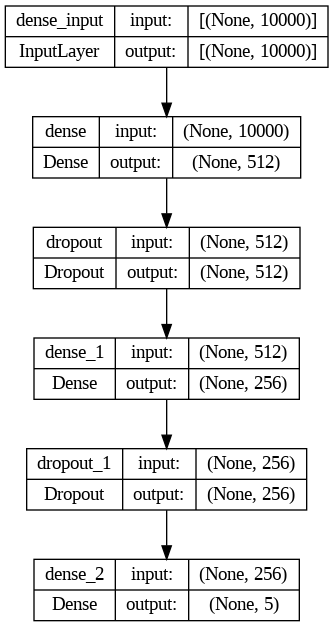

In [9]:
from tensorflow.keras.utils import plot_model
# Визуализация архитектуры модели
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

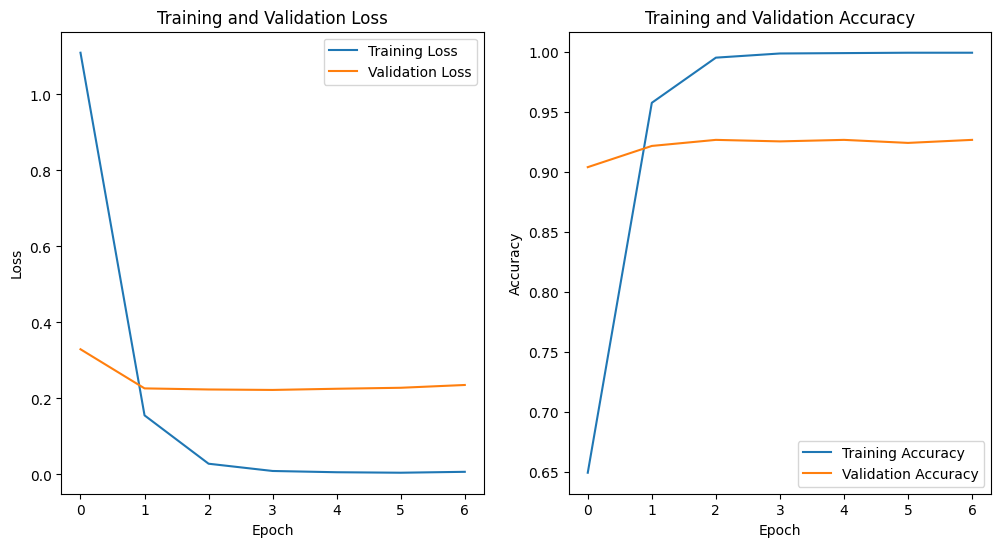

In [10]:
import matplotlib.pyplot as plt

# Визуализация истории обучения
plt.figure(figsize=(12, 6))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [11]:
import pickle
import tensorflow as tf

# Сохранение модели
model.save('fashion_recommender_model.h5')

# Сохранение vectorizer и label_encoder
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
import json

# Загрузка списка научной литературы
with open('scientific_literature.json', 'r', encoding='utf-8') as f:
    literature_data = json.load(f)

def predict_topic(theme):
    # Преобразование текста в TF-IDF вектор
    text_tfidf = vectorizer.transform([theme])

    # Прогнозирование метки
    predicted_probabilities = model.predict(text_tfidf.toarray())

    # Преобразование метки в категорию
    predicted_label_index = predicted_probabilities.argmax()
    predicted_category = label_encoder.inverse_transform([predicted_label_index])

    return predicted_category[0]

def get_literature_list(topic):
    return literature_data.get(topic, [])

theme = input('Введите вашу тему ВКР:')
if theme:
  predicted_category = predict_topic(theme)
  print(f'Категория: {predicted_category}')

  literature_list = get_literature_list(predicted_category)
  if literature_list:
    print(f'\nРекомендуемая литература по теме "{predicted_category}":\n')
    for item in literature_list:
      print(f"**Название:** {item['title']}")
      print(f"**Авторы:** {', '.join(item['authors'])}")
      print(f"**Журнал:** {item['journal']}")
      print(f"**Год:** {item['year']}")
      print(f"**URL:** [ссылка]({item['url']})\n")
  else:
    print(f'Нет доступной литературы по теме "{predicted_category}".')

Введите вашу тему ВКР:Криптографические методы
1/1 [==============================] - 0s 22ms/step
Категория: криптография

Рекомендуемая литература по теме "криптография":

**Название:** Constrained Device Performance Benchmarking with the Implementation of Post-Quantum Cryptography
**Авторы:** Gregory Fitzgibbon, Carlo Ottaviani
**Журнал:** Cryptography
**Год:** 2024
**URL:** [ссылка](https://www.mdpi.com/2410-387X/8/2/21)

**Название:** Special Issue on Cryptography and Information Security
**Авторы:** Lip Yee Por, Jing Yang, Chin Soon Ku, Abdullah Ayub Khan
**Журнал:** Applied Sciences
**Год:** 2023
**URL:** [ссылка](https://www.mdpi.com/2410-387X/8/2/21)

**Название:** E-Coin-Based Priced Oblivious Transfer with a Fast Item Retrieval
**Авторы:** Author Unknown
**Журнал:** Cryptography
**Год:** 2024
**URL:** [ссылка](https://www.mdpi.com/2410-387X/8/2/21)

**Название:** NLU-V: A Family of Instruction Set Extensions for Efficient Symmetric Cryptography on RISC-V
**Авторы:** Author U

## Этапы выполнения

Произвести математический расчет нейронной сети. Выбрать функцию активации нейронной сети. Вычислить вес нейронов.

    Функции активации выбраны relu для скрытых слоев и softmax для выходного слоя.
    Веса нейронов будут оптимизированы в процессе обучения.
    Процесс обратного распространения ошибки реализован с использованием метода adam.

Рассчитать оптимальную скорость обучения нейросети.

    Скорость обучения будет автоматически подбираться алгоритмом adam.

Рассчитать процесс обратного распространения ошибки.

    Обратное распространение ошибки реализовано внутри метода fit модели Keras.

Все расчеты должны сопровождаться графиками и схемами.

    Графики точности и потерь строятся после обучения модели.

Создать нейроны и нейронные блоки на языке программирования Python.

    Модель состоит из слоев Dense и Dropout.

Произвести выбор топологии сети.

    Выбрана многослойная сеть с двумя скрытыми слоями: 512 и 256 нейронов.

Сгруппировать нейронные блоки в нейронную сеть.

    Слои сгруппированы в последовательную модель Sequential.

Произвести экспериментальный подбор характеристик сети.

    Количество слоев, нейронов, функция активации и другие параметры выбраны экспериментально.

Обосновать выбор характеристик.

    Использованы общепринятые архитектуры и параметры для задач классификации текстов.

Собрать данные для обучения нейронной сети.

    Данные загружены из CSV файла, обработаны и преобразованы в TF-IDF векторы.

Произвести подготовку и нормализацию данных для обучения нейронной сети.

    Данные нормализованы с использованием TF-IDF векторизации.

Произвести экспериментальный подбор параметров обучения.

    Параметры обучения (количество эпох, размер батча) выбраны на основе валидации.

Произвести обучение нейросети на основе обучающей выборки.

    Обучение проведено с использованием метода fit.

Выбрать способ оценки того, насколько хорошо сеть справляется с задачами.

    Используется точность на тестовых данных.

Рассчитать количество потерь в тренировке и произвести их минимизацию.

    Потери рассчитываются с использованием функции loss.

Проверить адекватность обучения.

    Адекватность проверяется с помощью графиков и точности на тестовых данных.